# Sector Rotation Modeling Using Yahoo Finance & Machine Learning

## Dataset

In this project, I get my dataset from yahoo finance using the OpenBB sdk. We start by defining our list of sector symbols on a daily frequency over the last 24 years.

In [1]:
import os
from openbb import obb
import pandas as pd
#keys
obb_api_key = os.environ['OPENBB_API_KEY']
fred_api_key = os.environ['FRED_API_KEY']
obb.account.login(pat=obb_api_key)

obb.user.preferences.output_type = "dataframe"

In [2]:
sectors = ['SP500-15', 'SP500-20', 'SP500-25', 'SP500-30', 'SP500-35', 'SP500-40', 'SP500-45', 'SP500-50', 'SP500-55', 'SP500-60']

df_d= obb.index.price.historical(symbol = sectors,
                                 start_date='2000-01-01',
                                 end_date = '2024-01-01',
                                 interval = '1d',
                                 provider = 'yfinance')

df_d.reset_index(inplace=True)
df_d['date'] = pd.to_datetime(df_d['date'])
df_d.set_index(['date','symbol'],inplace=True)

df_d.head()

open        high         low       close  volume
date       symbol                                                           
2000-01-03 ^SP500-15  157.240005  157.240005  157.240005  157.240005       0
           ^SP500-20  265.609985  265.609985  265.609985  265.609985       0
           ^SP500-25  291.390015  291.390015  291.390015  291.390015       0
           ^SP500-30  204.229996  204.229996  204.229996  204.229996       0
           ^SP500-35  325.119995  325.119995  325.119995  325.119995       0

## Factor Construction / Feature Engineering
Next, we calculate some features to use downstream in our models.

In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.arima.model import ARIMA
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
import xgboost as xgb
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split

# Feature engineering functions
def calculate_roc(df, window):
    df[f'roc_{window}'] = df['close'].pct_change(window) * 100
    return df

def calculate_rsi(df, window):
    delta = df['close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    df[f'rsi_{window}'] = 100 - (100 / (1 + rs))
    return df

def calculate_macd(df, fast_window, slow_window, signal_window):
    df[f'ema_fast_{fast_window}'] = df['close'].ewm(span=fast_window, adjust=False).mean()
    df[f'ema_slow_{slow_window}'] = df['close'].ewm(span=slow_window, adjust=False).mean()
    df[f'macd_{fast_window}_{slow_window}'] = df[f'ema_fast_{fast_window}'] - df[f'ema_slow_{slow_window}']
    df[f'macd_signal_{signal_window}'] = df[f'macd_{fast_window}_{slow_window}'].ewm(span=signal_window, adjust=False).mean()
    df.drop(columns=[f'ema_fast_{fast_window}', f'ema_slow_{slow_window}'], inplace=True)
    return df

def calculate_bollinger_bands(df, window, num_std_dev=2):
    df[f'sma_{window}'] = df['close'].rolling(window).mean()
    df[f'std_dev_{window}'] = df['close'].rolling(window).std()
    df[f'bollinger_upper_{window}'] = df[f'sma_{window}'] + (df[f'std_dev_{window}'] * num_std_dev)
    df[f'bollinger_lower_{window}'] = df[f'sma_{window}'] - (df[f'std_dev_{window}'] * num_std_dev)
    df.drop(columns=[f'sma_{window}', f'std_dev_{window}'], inplace=True)
    return df

def calculate_atr(df, window):
    high_low = df['high'] - df['low']
    high_close = (df['high'] - df['close'].shift()).abs()
    low_close = (df['low'] - df['close'].shift()).abs()
    true_range = pd.DataFrame({
        'high_low': high_low,
        'high_close': high_close,
        'low_close': low_close
    })
    true_range['tr'] = true_range.max(axis=1)
    df[f'atr_{window}'] = true_range['tr'].rolling(window).mean()
    return df

def calculate_ema_volatility(df, window):
    df['log_return'] = np.log(df['close'] / df['close'].shift(1))
    df['squared_log_return'] = df['log_return'] ** 2
    df[f'ema_volatility_{window}'] = df['squared_log_return'].ewm(span=window, adjust=False).mean() ** 0.5
    df.drop(columns=['log_return', 'squared_log_return'], inplace=True)
    return df

def apply_metrics(df, short_term, medium_term, long_term):
    windows = [short_term, medium_term, long_term]
    
    for window in windows:
        df = df.groupby('symbol', group_keys=False).apply(calculate_roc, window=window)
        df = df.groupby('symbol', group_keys=False).apply(calculate_rsi, window=window)
        df = df.groupby('symbol', group_keys=False).apply(calculate_bollinger_bands, window=window)
        df = df.groupby('symbol', group_keys=False).apply(calculate_atr, window=window)
        df = df.groupby('symbol', group_keys=False).apply(calculate_ema_volatility, window=window)
    
    macd_windows = [(short_term, medium_term, short_term), (medium_term, long_term, medium_term)]
    for fast_window, slow_window, signal_window in macd_windows:
        df = df.groupby('symbol', group_keys=False).apply(calculate_macd, fast_window=fast_window, slow_window=slow_window, signal_window=signal_window)
    
    return df

# Define the time windows
short_term = 5
medium_term = 20
long_term = 50

df_pre = df_d.drop(columns = ['volume']).copy()

df = apply_metrics(df_pre, short_term, medium_term, long_term)

df.tail()

open         high          low        close  \
date       symbol                                                          
2023-12-29 ^SP500-40   627.789978   628.840027   624.359985   626.349976   
           ^SP500-45  3412.050049  3417.179932  3378.979980  3397.159912   
           ^SP500-50   246.910004   247.279999   244.710007   246.000000   
           ^SP500-55   321.040009   322.399994   319.739990   321.920013   
           ^SP500-60   252.309998   253.250000   250.779999   250.960007   

                         roc_5      rsi_5  bollinger_upper_5  \
date       symbol                                              
2023-12-29 ^SP500-40  0.944413  81.303390         629.989273   
           ^SP500-45  0.305889  67.666994        3413.283217   
           ^SP500-50 -0.235219  40.202694         248.125311   
           ^SP500-55  1.481625  88.907527         323.732187   
           ^SP500-60  0.916847  63.603919         255.151219   

                      bollinger_lower_5      atr_5  ema_volatility_5  ...  \
date       symbol                                                     ...   
2023-12-29 ^SP500-40         620.698691   4.182007          0.004823  ...   
           ^SP500-45        3385.092760  24.867920          0.004260  ...   
           ^SP500-50         245.798694   1.925995          0.004779  ...   
           ^SP500-55         317.351809   3.178003          0.006144  ...   
           ^SP500-60         248.272786   2.574002          0.009251  ...   

                         roc_50     rsi_50  bollinger_upper_50  \
date       symbol                                                
2023-12-29 ^SP500-40  13.644189  69.001402          645.260636   
           ^SP500-45  14.585812  67.853807         3552.463709   
           ^SP500-50   7.348576  58.391467          251.695193   
           ^SP500-55   7.103173  57.949220          331.220742   
           ^SP500-60  18.752664  66.371980          260.704772   

                      bollinger_lower_50     atr_50  ema_volatility_50  \
date       symbol                                                        
2023-12-29 ^SP500-40          518.192157   6.135801           0.007968   
           ^SP500-45         2846.716711  43.665781           0.008963   
           ^SP500-50          216.302007   3.651600           0.010894   
           ^SP500-55          295.653658   4.896599           0.011637   
           ^SP500-60          195.143630   3.851800           0.013113   

                      macd_5_20  macd_signal_5  macd_20_50  macd_signal_20  
date       symbol                                                           
2023-12-29 ^SP500-40  12.336821      13.299865   19.751487       15.388918  
           ^SP500-45  49.232157      55.290425  105.234450       96.690521  
           ^SP500-50   4.639465       4.893686    5.376250        4.042282  
           ^SP500-55   1.123608       0.977270    3.401343        2.886073  
           ^SP500-60   6.871204       7.513593   10.068566        7.211387  

[5 rows x 26 columns]

## Prep Data for ML Modeling
Then, we clean our final dataset and scale the features before fitting a few different models

In [4]:
# Data cleaning function
def clean_data(df):
    df = df.dropna()
    df['open'] = df['open'].astype(float)
    df['high'] = df['high'].astype(float)
    df['low'] = df['low'].astype(float)
    df['close'] = df['close'].astype(float)
    return df

# Scale features
def scale_features(df):
    scaler = StandardScaler()
    df = scaler.fit_transform(df)
    return df, scaler

def fit_random_forest(X_train, X_test, y_train, y_test):
    model = RandomForestRegressor(n_estimators=100,max_depth = 5)
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    return model,predictions

def fit_extra_trees(X_train, X_test, y_train, y_test):
    model = ExtraTreesRegressor(n_estimators=100,max_depth = 5)
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    return model,predictions

def fit_xgboost(X_train, X_test, y_train, y_test):
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)
    params = {
        'objective': 'reg:squarederror',
        'max_depth': 5,
        'eta': 0.1,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
    }
    model = xgb.train(params, dtrain, num_boost_round=100)
    predictions = model.predict(dtest)
    return model,predictions

def fit_catboost(X_train, X_test, y_train, y_test):
    model = CatBoostRegressor(iterations=100, depth=5, learning_rate=0.1, loss_function='RMSE', verbose=0)
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    return model,predictions



df['ret'] = df['close'].pct_change()
df['ret']=df['ret'].unstack().shift(-1).stack()



# Filter for dates after a certain date
after_date = pd.Timestamp('2020-01-01')
df_os = df.loc[(df_d.index.get_level_values('date') > after_date)].copy()

df_t =  df.loc[(df_d.index.get_level_values('date') <= after_date)].copy()


df=clean_data(df_t)

features = df.drop(columns=['ret','close']).values
target = df['ret'].values
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, shuffle=False)

X_train, X_scaler = scale_features(X_train)


C:\Users\Nick\AppData\Local\Temp\ipykernel_2584\3896874972.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['open'] = df['open'].astype(float)
C:\Users\Nick\AppData\Local\Temp\ipykernel_2584\3896874972.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['high'] = df['high'].astype(float)
C:\Users\Nick\AppData\Local\Temp\ipykernel_2584\3896874972.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



In [5]:

rf_model,random_forest_predictions = fit_random_forest(X_train, X_test, y_train, y_test)
et_model,extra_trees_predictions = fit_extra_trees(X_train, X_test, y_train, y_test)
xb_model,xgboost_predictions = fit_xgboost(X_train, X_test, y_train, y_test)
cb_model,catboost_predictions = fit_catboost(X_train, X_test, y_train, y_test)


## Analyze Results

### Feature Importance of RF Model

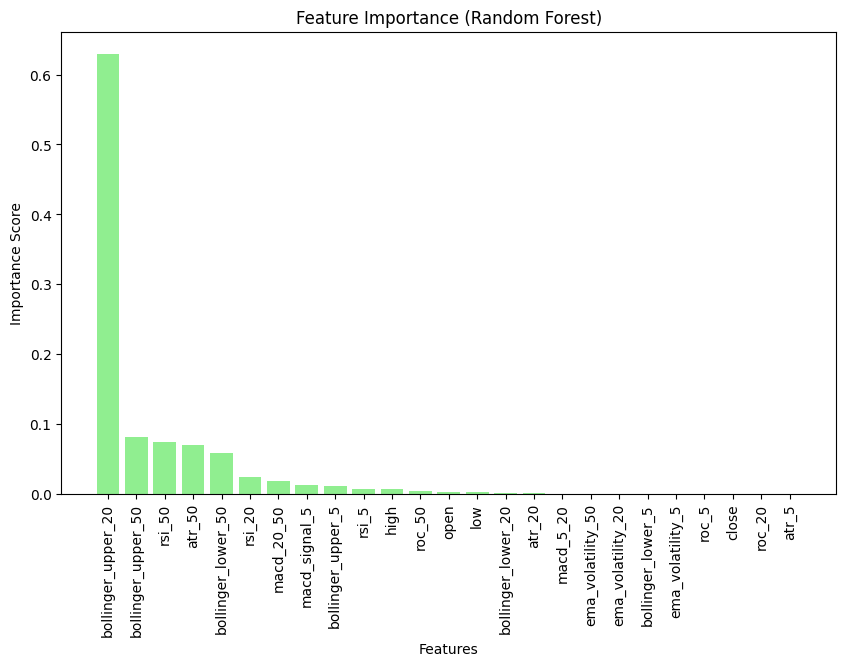

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Get feature importance from the Random Forest model
importances = rf_model.feature_importances_

# Sort the feature importances in descending order
indices = np.argsort(importances)[::-1]

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.bar(range(len(importances)), importances[indices], color='lightgreen', align='center')
plt.xticks(range(len(importances)), [df.columns[i] for i in indices], rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance Score')
plt.title('Feature Importance (Random Forest)')
plt.show()

### RMSE Comparison

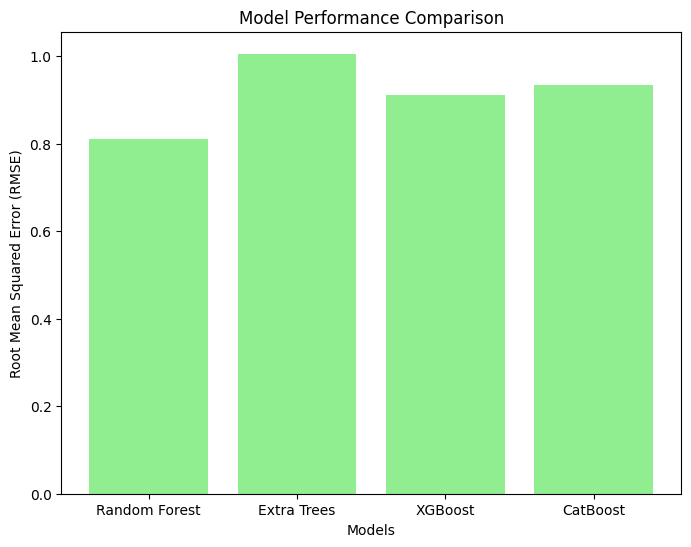

In [7]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Calculate RMSE for each model
rmse_random_forest = np.sqrt(mean_squared_error(y_test, random_forest_predictions))
rmse_extra_trees = np.sqrt(mean_squared_error(y_test, extra_trees_predictions))
rmse_xgboost = np.sqrt(mean_squared_error(y_test, xgboost_predictions))
rmse_catboost = np.sqrt(mean_squared_error(y_test, catboost_predictions))

# Plot the RMSE for each model
models = ['Random Forest', 'Extra Trees', 'XGBoost', 'CatBoost']
rmse_values = [rmse_random_forest, rmse_extra_trees, rmse_xgboost, rmse_catboost]

plt.figure(figsize=(8, 6))
plt.bar(models, rmse_values, color='lightgreen')
plt.xlabel('Models')
plt.ylabel('Root Mean Squared Error (RMSE)')
plt.title('Model Performance Comparison')
plt.show()

### Residuals

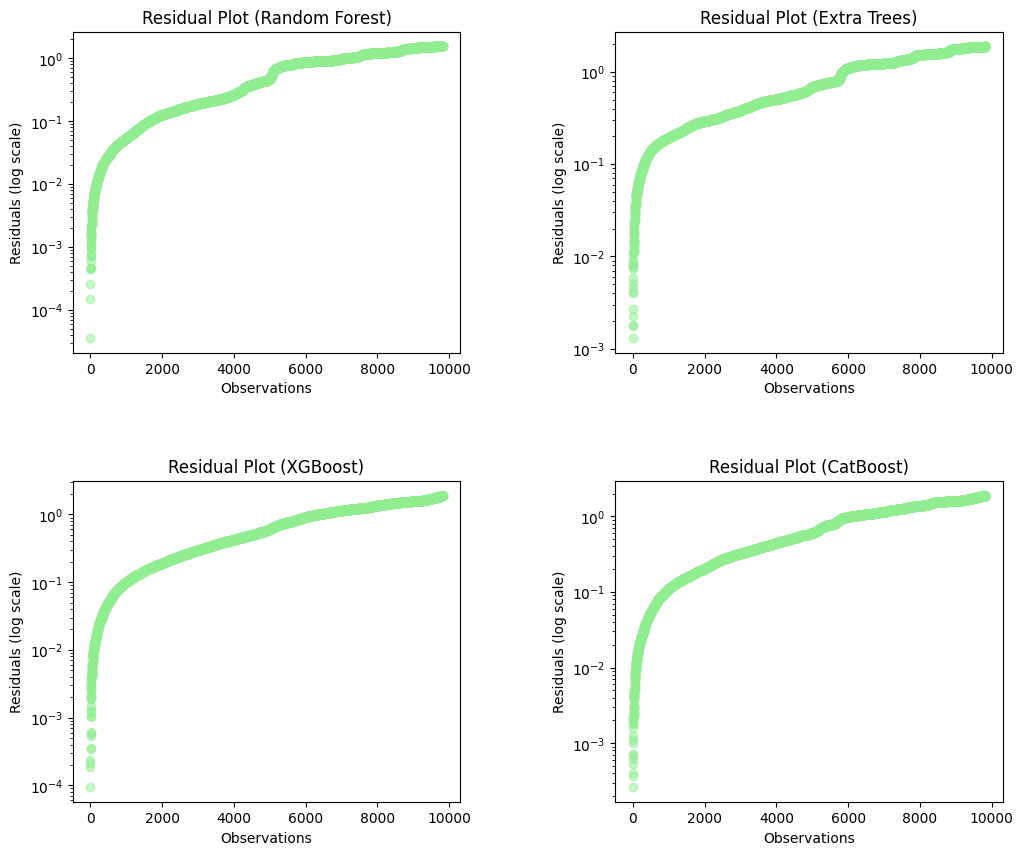

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate residuals for each model
residuals_random_forest = y_test - random_forest_predictions
residuals_extra_trees = y_test - extra_trees_predictions
residuals_xgboost = y_test - xgboost_predictions
residuals_catboost = y_test - catboost_predictions

# Set up the subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
axs = axs.ravel()  # Flatten the array of subplots

# Plot the residuals for each model on a different subplot
models = ['Random Forest', 'Extra Trees', 'XGBoost', 'CatBoost']
residuals = [residuals_random_forest, residuals_extra_trees, residuals_xgboost, residuals_catboost]

for i, (ax, model_name, residual) in enumerate(zip(axs, models, residuals)):
    sorted_residuals = np.sort(np.abs(residual))
    ax.semilogy(range(len(sorted_residuals)), sorted_residuals, 'o', color='lightgreen', alpha=0.5)
    ax.axhline(y=0, color='r', linestyle='--')
    ax.set_title(f'Residual Plot ({model_name})')
    ax.set_xlabel('Observations')
    ax.set_ylabel('Residuals (log scale)')

# Adjust spacing between subplots
fig.subplots_adjust(hspace=0.4, wspace=0.4)

# Show the plot
plt.show()

## Ensemble Models

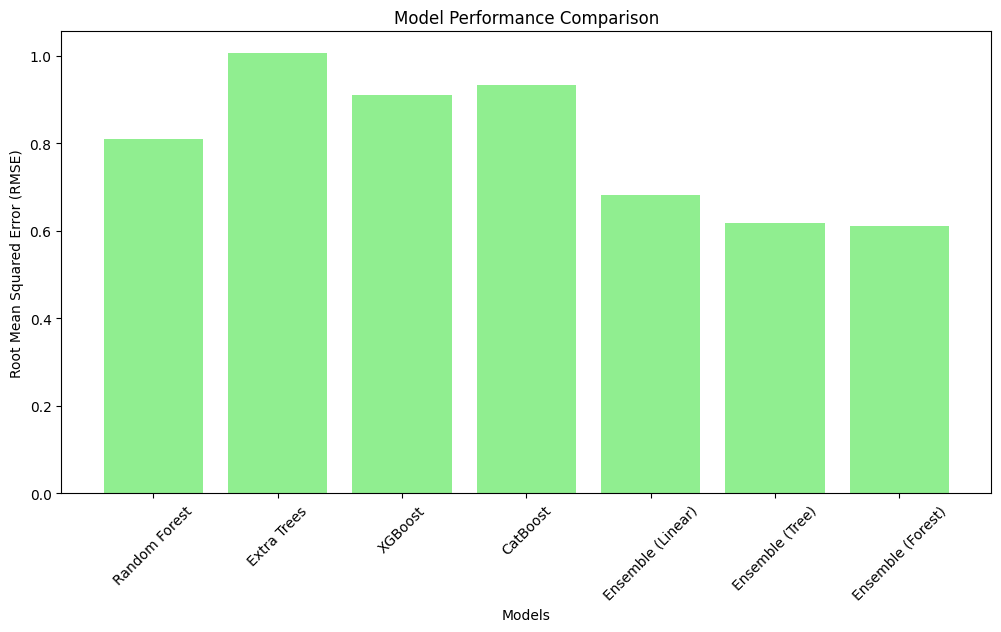

In [9]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Combine the predictions from individual models into a single array
individual_predictions = np.column_stack((random_forest_predictions, extra_trees_predictions,
                                          xgboost_predictions, catboost_predictions))

# Create ensemble models
ensemble_linear = LinearRegression()
ensemble_linear.fit(individual_predictions, y_test)
ensemble_linear_predictions = ensemble_linear.predict(individual_predictions)

ensemble_tree = DecisionTreeRegressor(max_depth=5)
ensemble_tree.fit(individual_predictions, y_test)
ensemble_tree_predictions = ensemble_tree.predict(individual_predictions)

ensemble_forest = RandomForestRegressor(n_estimators=100, max_depth=5)
ensemble_forest.fit(individual_predictions, y_test)
ensemble_forest_predictions = ensemble_forest.predict(individual_predictions)

# Calculate RMSE for individual models and ensemble models
rmse_random_forest = np.sqrt(mean_squared_error(y_test, random_forest_predictions))
rmse_extra_trees = np.sqrt(mean_squared_error(y_test, extra_trees_predictions))
rmse_xgboost = np.sqrt(mean_squared_error(y_test, xgboost_predictions))
rmse_catboost = np.sqrt(mean_squared_error(y_test, catboost_predictions))
rmse_ensemble_linear = np.sqrt(mean_squared_error(y_test, ensemble_linear_predictions))
rmse_ensemble_tree = np.sqrt(mean_squared_error(y_test, ensemble_tree_predictions))
rmse_ensemble_forest = np.sqrt(mean_squared_error(y_test, ensemble_forest_predictions))

# Plot the RMSE for individual models and ensemble models
models = ['Random Forest', 'Extra Trees', 'XGBoost', 'CatBoost',
          'Ensemble (Linear)', 'Ensemble (Tree)', 'Ensemble (Forest)']
rmse_values = [rmse_random_forest, rmse_extra_trees, rmse_xgboost, rmse_catboost,
               rmse_ensemble_linear, rmse_ensemble_tree, rmse_ensemble_forest]

plt.figure(figsize=(12, 6))
plt.bar(models, rmse_values, color='lightgreen')
plt.xlabel('Models')
plt.ylabel('Root Mean Squared Error (RMSE)')
plt.title('Model Performance Comparison')
plt.xticks(rotation=45)
plt.show()

### Model Performance over Time

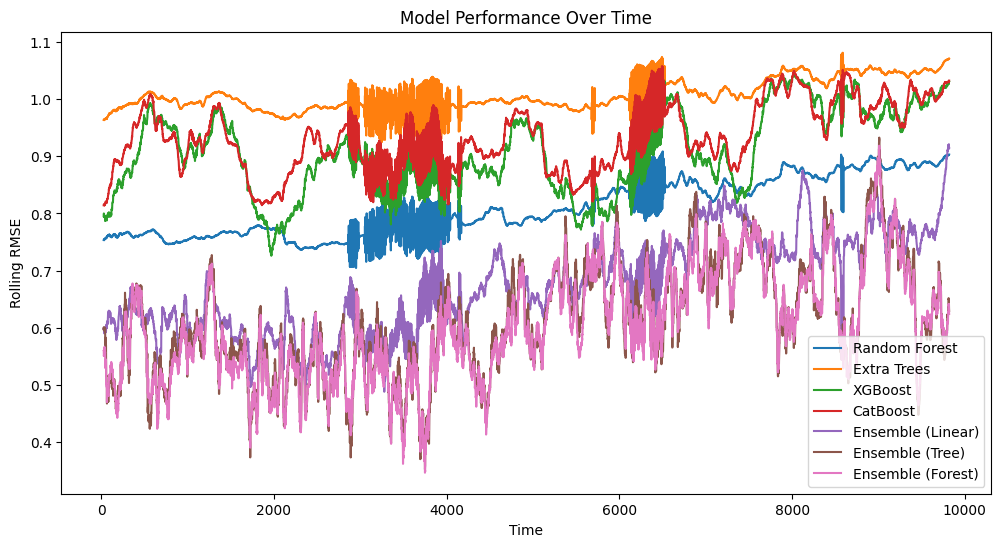

In [10]:
import pandas as pd
from sklearn.metrics import mean_squared_error

# Assuming you have the actual target values (y_test) and predictions from each model
# in separate numpy arrays or pandas Series

# Convert to pandas Series
y_test_series = pd.Series(y_test)
random_forest_predictions_series = pd.Series(random_forest_predictions)
extra_trees_predictions_series = pd.Series(extra_trees_predictions)
xgboost_predictions_series = pd.Series(xgboost_predictions)
catboost_predictions_series = pd.Series(catboost_predictions)
ensemble_linear_predictions_series = pd.Series(ensemble_linear_predictions)
ensemble_tree_predictions_series = pd.Series(ensemble_tree_predictions)
ensemble_forest_predictions_series = pd.Series(ensemble_forest_predictions)

# Create a rolling window of size 30
window_size = 30

# Calculate rolling RMSE for each model
rmse_random_forest_rolling = y_test_series.rolling(window_size).apply(
    lambda x: np.sqrt(mean_squared_error(x, random_forest_predictions_series[x.index])))
rmse_extra_trees_rolling = y_test_series.rolling(window_size).apply(
    lambda x: np.sqrt(mean_squared_error(x, extra_trees_predictions_series[x.index])))
rmse_xgboost_rolling = y_test_series.rolling(window_size).apply(
    lambda x: np.sqrt(mean_squared_error(x, xgboost_predictions_series[x.index])))
rmse_catboost_rolling = y_test_series.rolling(window_size).apply(
    lambda x: np.sqrt(mean_squared_error(x, catboost_predictions_series[x.index])))
rmse_ensemble_linear_rolling = y_test_series.rolling(window_size).apply(
    lambda x: np.sqrt(mean_squared_error(x, ensemble_linear_predictions_series[x.index])))
rmse_ensemble_tree_rolling = y_test_series.rolling(window_size).apply(
    lambda x: np.sqrt(mean_squared_error(x, ensemble_tree_predictions_series[x.index])))
rmse_ensemble_forest_rolling = y_test_series.rolling(window_size).apply(
    lambda x: np.sqrt(mean_squared_error(x, ensemble_forest_predictions_series[x.index])))

# Plot the rolling RMSE for each model
plt.figure(figsize=(12, 6))
plt.plot(rmse_random_forest_rolling, label='Random Forest')
plt.plot(rmse_extra_trees_rolling, label='Extra Trees')
plt.plot(rmse_xgboost_rolling, label='XGBoost')
plt.plot(rmse_catboost_rolling, label='CatBoost')
plt.plot(rmse_ensemble_linear_rolling, label='Ensemble (Linear)')
plt.plot(rmse_ensemble_tree_rolling, label='Ensemble (Tree)')
plt.plot(rmse_ensemble_forest_rolling, label='Ensemble (Forest)')
plt.xlabel('Time')
plt.ylabel('Rolling RMSE')
plt.title('Model Performance Over Time')
plt.legend()
plt.show()

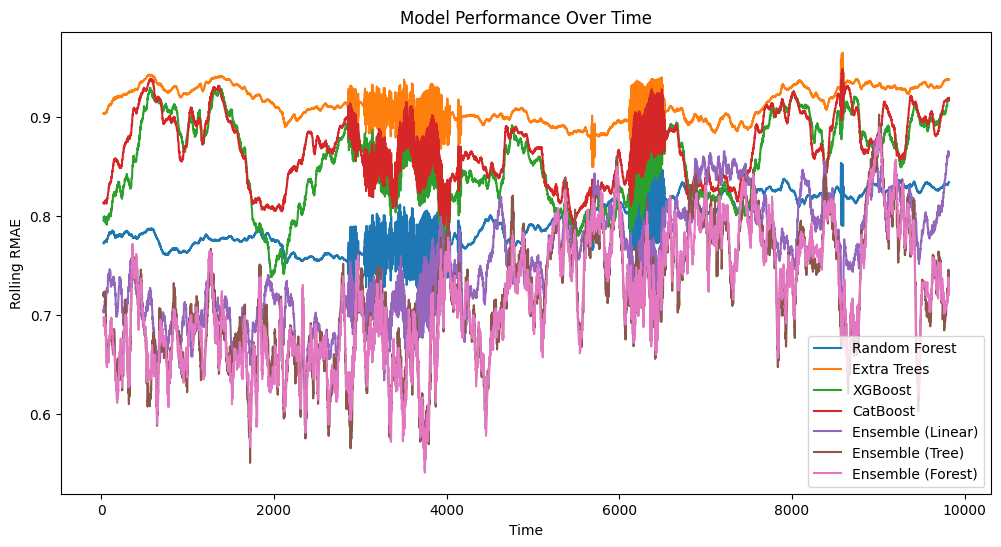

In [11]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# Calculate rolling RMSE for each model
rmae_random_forest_rolling = y_test_series.rolling(window_size).apply(
    lambda x: np.sqrt(mean_absolute_error(x, random_forest_predictions_series[x.index])))
rmae_extra_trees_rolling = y_test_series.rolling(window_size).apply(
    lambda x: np.sqrt(mean_absolute_error(x, extra_trees_predictions_series[x.index])))
rmae_xgboost_rolling = y_test_series.rolling(window_size).apply(
    lambda x: np.sqrt(mean_absolute_error(x, xgboost_predictions_series[x.index])))
rmae_catboost_rolling = y_test_series.rolling(window_size).apply(
    lambda x: np.sqrt(mean_absolute_error(x, catboost_predictions_series[x.index])))
rmae_ensemble_linear_rolling = y_test_series.rolling(window_size).apply(
    lambda x: np.sqrt(mean_absolute_error(x, ensemble_linear_predictions_series[x.index])))
rmae_ensemble_tree_rolling = y_test_series.rolling(window_size).apply(
    lambda x: np.sqrt(mean_absolute_error(x, ensemble_tree_predictions_series[x.index])))
rmae_ensemble_forest_rolling = y_test_series.rolling(window_size).apply(
    lambda x: np.sqrt(mean_absolute_error(x, ensemble_forest_predictions_series[x.index])))

# Plot the rolling RMSE for each model
plt.figure(figsize=(12, 6))
plt.plot(rmae_random_forest_rolling, label='Random Forest')
plt.plot(rmae_extra_trees_rolling, label='Extra Trees')
plt.plot(rmae_xgboost_rolling, label='XGBoost')
plt.plot(rmae_catboost_rolling, label='CatBoost')
plt.plot(rmae_ensemble_linear_rolling, label='Ensemble (Linear)')
plt.plot(rmae_ensemble_tree_rolling, label='Ensemble (Tree)')
plt.plot(rmae_ensemble_forest_rolling, label='Ensemble (Forest)')
plt.xlabel('Time')
plt.ylabel('Rolling RMAE')
plt.title('Model Performance Over Time')
plt.legend()
plt.show()

In [12]:
os_ret = df_os['ret']
df_os=df_os.drop(columns = ['close','ret'])
df_train_os = X_scaler.fit_transform(df_os)

In [13]:
os_preds = []
for model in [rf_model,et_model,cb_model]:
    os_preds.append(model.predict(df_train_os))

os_preds.append(xb_model.predict(xgb.DMatrix(df_train_os)))


In [14]:
res_os = []
for pred in os_preds:
    res_os.append((pred-os_ret))

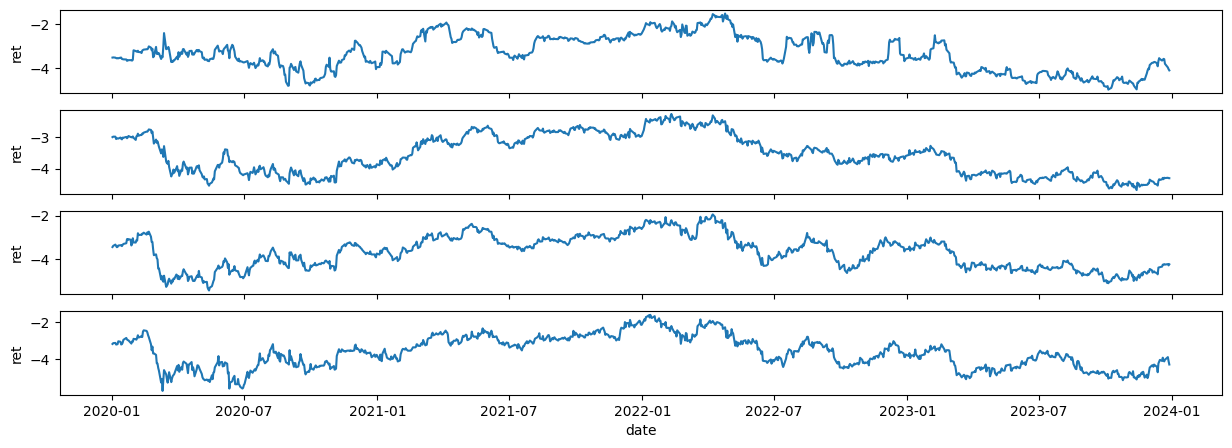

In [18]:
fig,axs = plt.subplots(4,1,figsize=(15,5),sharex=True)
import seaborn as sns
for x,res in enumerate(res_os):
    sns.lineplot(res.groupby('date').sum().iloc[:-1],ax=axs[x])

In [16]:
ensemble_os_preds=[]
ensemble_os_res=[]
# Combine the predictions from individual models into a single array
individual_predictions_os = np.column_stack((os_preds[0],os_preds[1],
                                          os_preds[3], os_preds[2]))

for ensemble in [ensemble_forest,ensemble_linear,ensemble_tree]:
    e_preds=ensemble.predict(individual_predictions_os)
    ensemble_os_preds.append(e_preds)
    ensemble_os_res.append((os_ret-e_preds))

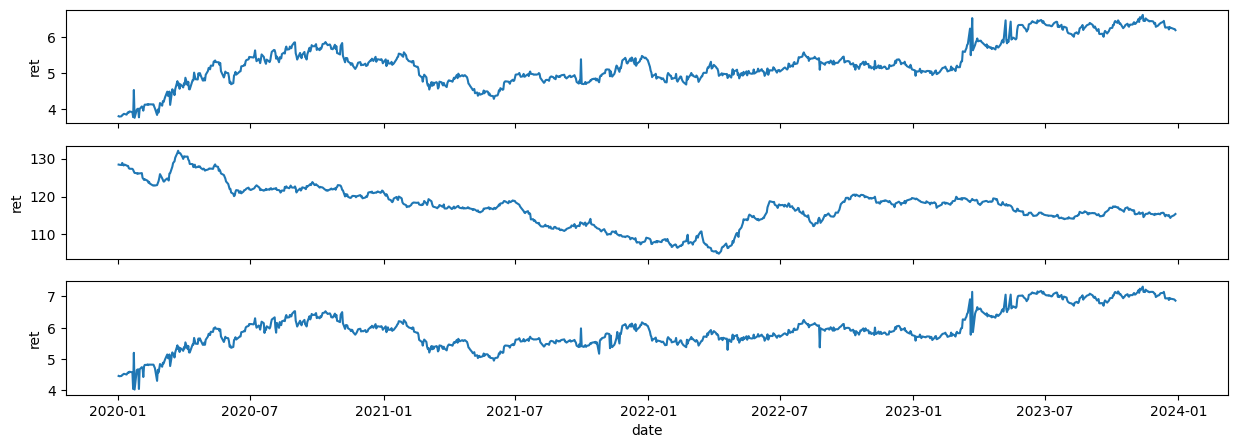

In [19]:
fig,axs = plt.subplots(3,1,figsize=(15,5),sharex=True)
import seaborn as sns
for x,res in enumerate(ensemble_os_res):
    sns.lineplot(res.groupby('date').sum().iloc[:-1],ax=axs[x])

### Next Steps
Need to look at backtest stats of predictions

-----